# Image inpainting

Philippe Massouf

Diego Torres

In [1]:
from PIL import Image
from functools import partial

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
n = 128
Jmax = np.log2(n)-1
Jmin = (Jmax-3)

J = Jmax-Jmin + 1
u = np.hstack(([4**(-J)], 4**(-np.floor(np.arange(J + 2./3,1,-1./3)))))
U = np.transpose(np.tile(u, (n,n,1)),(2,0,1))
tau = 1.9*np.min(u)

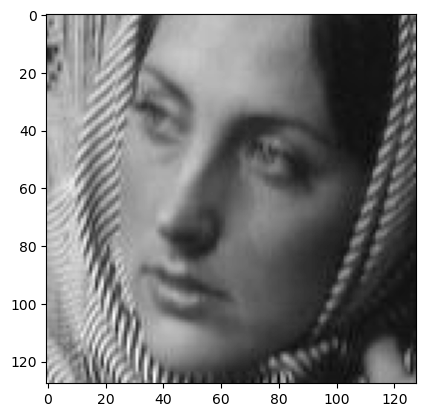

In [3]:
# Reading the image
img_pil = Image.open('barbara.jpg').convert("L")  # Convert to grayscale
img = np.array(img_pil)  # Convert PIL Image to NumPy array
img = img[60:60+n, 250:250+n]/255.  # Crop the image to n x n
plt.imshow(img, cmap='gray')
plt.show()

In [4]:
def generate_problem(img, *, p, snr):
    mask = np.random.binomial(1, 1-p, size=img.shape)  # Generate a random mask
    img_damaged = img * mask  # Damage the image
    img_damaged = np.clip(img_damaged + generate_noise(img, snr), 0, 1) # Add noise to the damaged image
    return img_damaged, mask

def generate_noise(img, snr):
    N= img.shape[0]*img.shape[1]
    noise_var = (np.sum(img**2)/N)* np.exp(-snr / 10)
    noise = np.random.normal(0, np.sqrt(noise_var), img.shape)
    return noise

def add_noise(img, snr):
    return img + generate_noise(img, snr)

def soft_thresholding(x, T):
    return x*np.maximum(1-T/np.maximum(abs(x), 1e-10*np.ones(np.shape(x))), np.zeros(np.shape(x)))

def hard_thresholding(x, T):
    return x*(np.abs(x) > T)

# Damaging the image

Here we'll simulate an inpainting problem by removing pixels from the image.

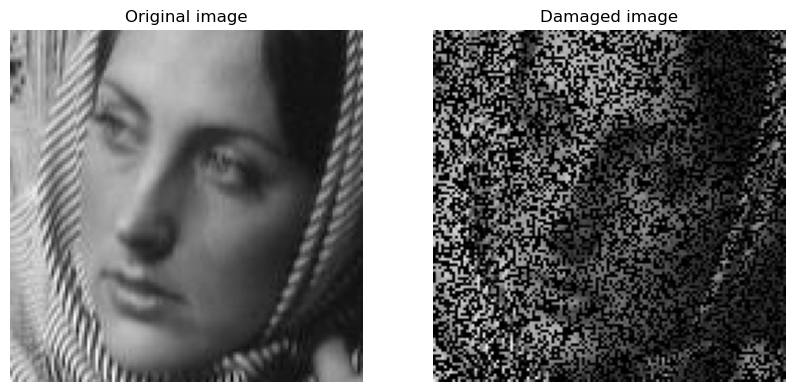

In [6]:
np.random.seed(10)

img_damaged, mask = generate_problem(img, p=0.5, snr=50)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(img, cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

ax2.imshow(img_damaged, cmap='gray')
ax2.set_title('Damaged image')
ax2.axis('off')

plt.show()

The new image has lost a significant amount of detail. We can try to recover the original image by using inpainting techniques.

In [7]:
from wavelet_transform import perform_wavelet_transf

def Xi(a, **kwargs):
    return perform_wavelet_transf(a, Jmin=Jmin, dir=-1, **kwargs)

def PsiS(f, **kwargs):
    return perform_wavelet_transf(f, Jmin=Jmin, dir=+1, **kwargs)

def Psi(a, **kwargs):
    return Xi(a/U, **kwargs)

def damage(x):
    return x * mask

def proj_c(image):
    return (1-mask)*image + mask*img_damaged

In [8]:
def soft_solution(img_damaged, *, niter, lamb_start, lamb_end, **wavelet_kwargs):
    lambda_list = np.linspace(lamb_start, lamb_end, niter)
    a = U*PsiS(img_damaged, **wavelet_kwargs)
    for i in tqdm(range(niter)):
        img_1 = Psi(a, **wavelet_kwargs)
        d = img_damaged-damage(img_1)
        a = soft_thresholding(a + tau*PsiS(damage(d), **wavelet_kwargs) , lambda_list[i]*tau) 
    return Psi(a, **wavelet_kwargs)

In [9]:
def hard_solution(img_damaged, *, niter, lamb_start, lamb_end, **wavelet_kwargs):
    lambda_list = np.linspace(lamb_start, lamb_end, niter)
    fixed_image = img_damaged.copy()
    for i in tqdm(range(niter)):
        fixed_image = Xi(hard_thresholding(PsiS(proj_c(fixed_image), **wavelet_kwargs), lambda_list[i]), **wavelet_kwargs)

    return fixed_image

## Changing the sparse representation

### 1. For the hard thresholding

In [10]:
translation_invariant = [False, True]
filter_type = ['linear', '7-9']

solutions = {}
for ti in translation_invariant:
    for filter in filter_type:
        solved_image = hard_solution(img_damaged, niter=50, lamb_start=1, lamb_end=0, ti=ti, filter=filter)
        solutions[(ti, filter)] = solved_image

100%|██████████| 50/50 [00:00<00:00, 100.61it/s]


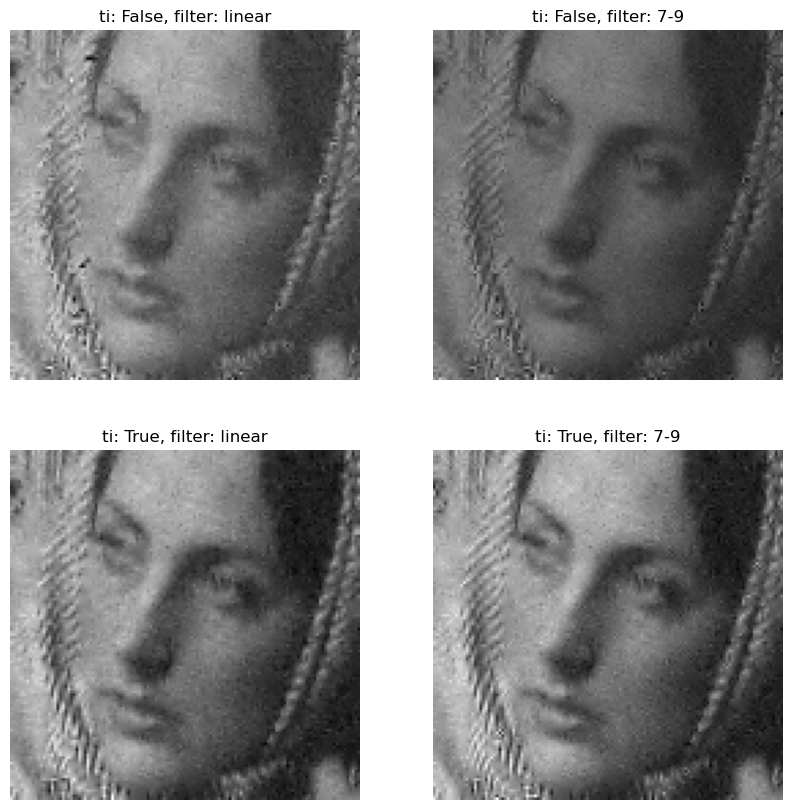

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, (ti, filter) in enumerate(solutions.keys()):
    axes[i//2, i%2].imshow(solutions[(ti, filter)], cmap='gray')
    axes[i//2, i%2].set_title(f'ti: {ti}, filter: {filter}')
    axes[i//2, i%2].axis('off')

When not applying translation invariance, the 7-9 filter demonstrates superior image quality compared to the linear filter. However, one notable downside is that the image appears darker. On the other hand, with the implementation of translation invariance, the 7-9 filter maintains its edge over the linear filter in terms of quality. Notably, this time, the image retains its brightness, ensuring that the visual output is not only sharper but also luminously consistent.

### 2. For the soft thresholding

In [12]:
solutions = {}
for filter in filter_type:
    solved_image = soft_solution(img_damaged, niter=500, lamb_start=0.5, lamb_end=0, ti=1, filter=filter)
    solutions[(ti, filter)] = solved_image

100%|██████████| 500/500 [00:04<00:00, 100.98it/s]


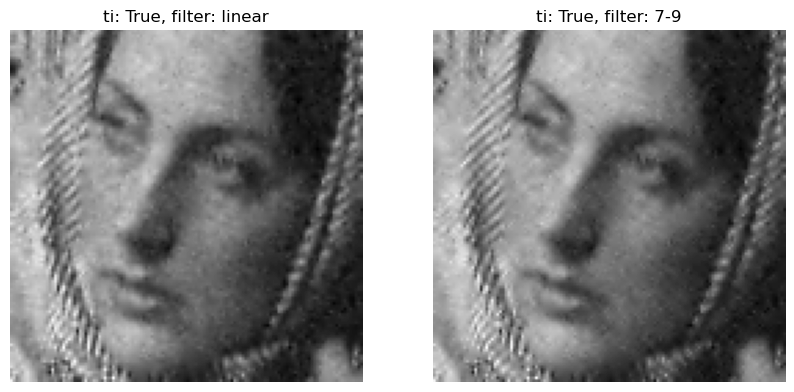

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


for i, (ti, filter) in enumerate(solutions.keys()):
    axs[i].imshow(solutions[(ti, filter)], cmap='gray')
    axs[i].set_title(f'ti: {ti}, filter: {filter}')
    axs[i].axis('off')

## Changing the thresholding

In [14]:
img_1 = soft_solution(img_damaged, niter=1000, lamb_start=0.5, lamb_end=0, ti=1, filter='linear')

100%|██████████| 1000/1000 [00:08<00:00, 111.43it/s]


In [15]:
img_2 = hard_solution(img_damaged, niter=500, lamb_start=0.5, lamb_end=0, ti=1, filter='linear')

100%|██████████| 500/500 [00:03<00:00, 150.24it/s]


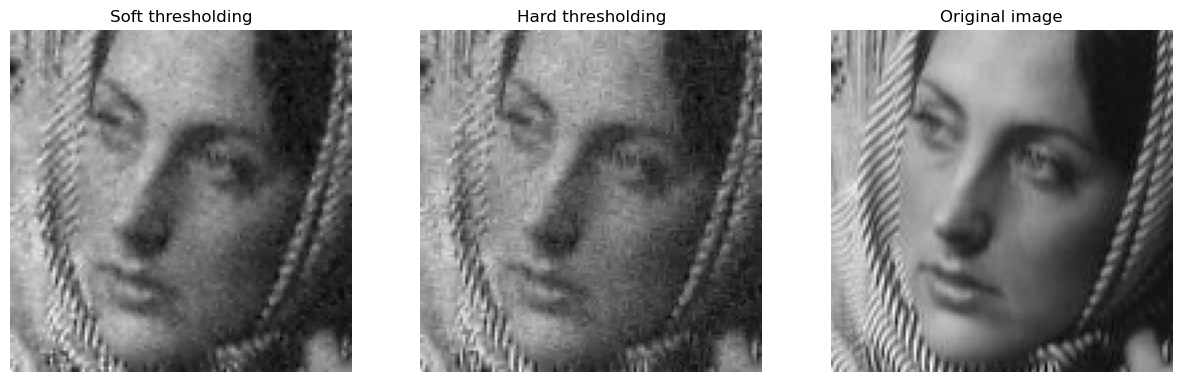

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(img_1, cmap='gray')
ax1.set_title('Soft thresholding')
ax1.axis('off')

ax2.imshow(img_2, cmap='gray')
ax2.set_title('Hard thresholding')
ax2.axis('off')

ax3.imshow(img, cmap='gray')
ax3.set_title('Original image')
ax3.axis('off')

plt.show()

Using soft thresholding, the 7-9 filter works better, just like in our other tests. The noise in the image is smoothed out over larger areas, making the picture look nicer to the eye.

## Changing $\lambda$

### 1. For the hard thresholding

In [17]:
solutions = {}

for lamb_start in [0.01, 0.1, 0.5, 1.]:
    for lamb_end in [1e-3, 1e-4, 1e-5, 0]:
        solved_image = hard_solution(img_damaged, niter=500, lamb_start=lamb_start, lamb_end=lamb_end, ti=1, filter='linear')
        solutions[(lamb_start, lamb_end)] = solved_image

100%|██████████| 500/500 [00:02<00:00, 168.05it/s]


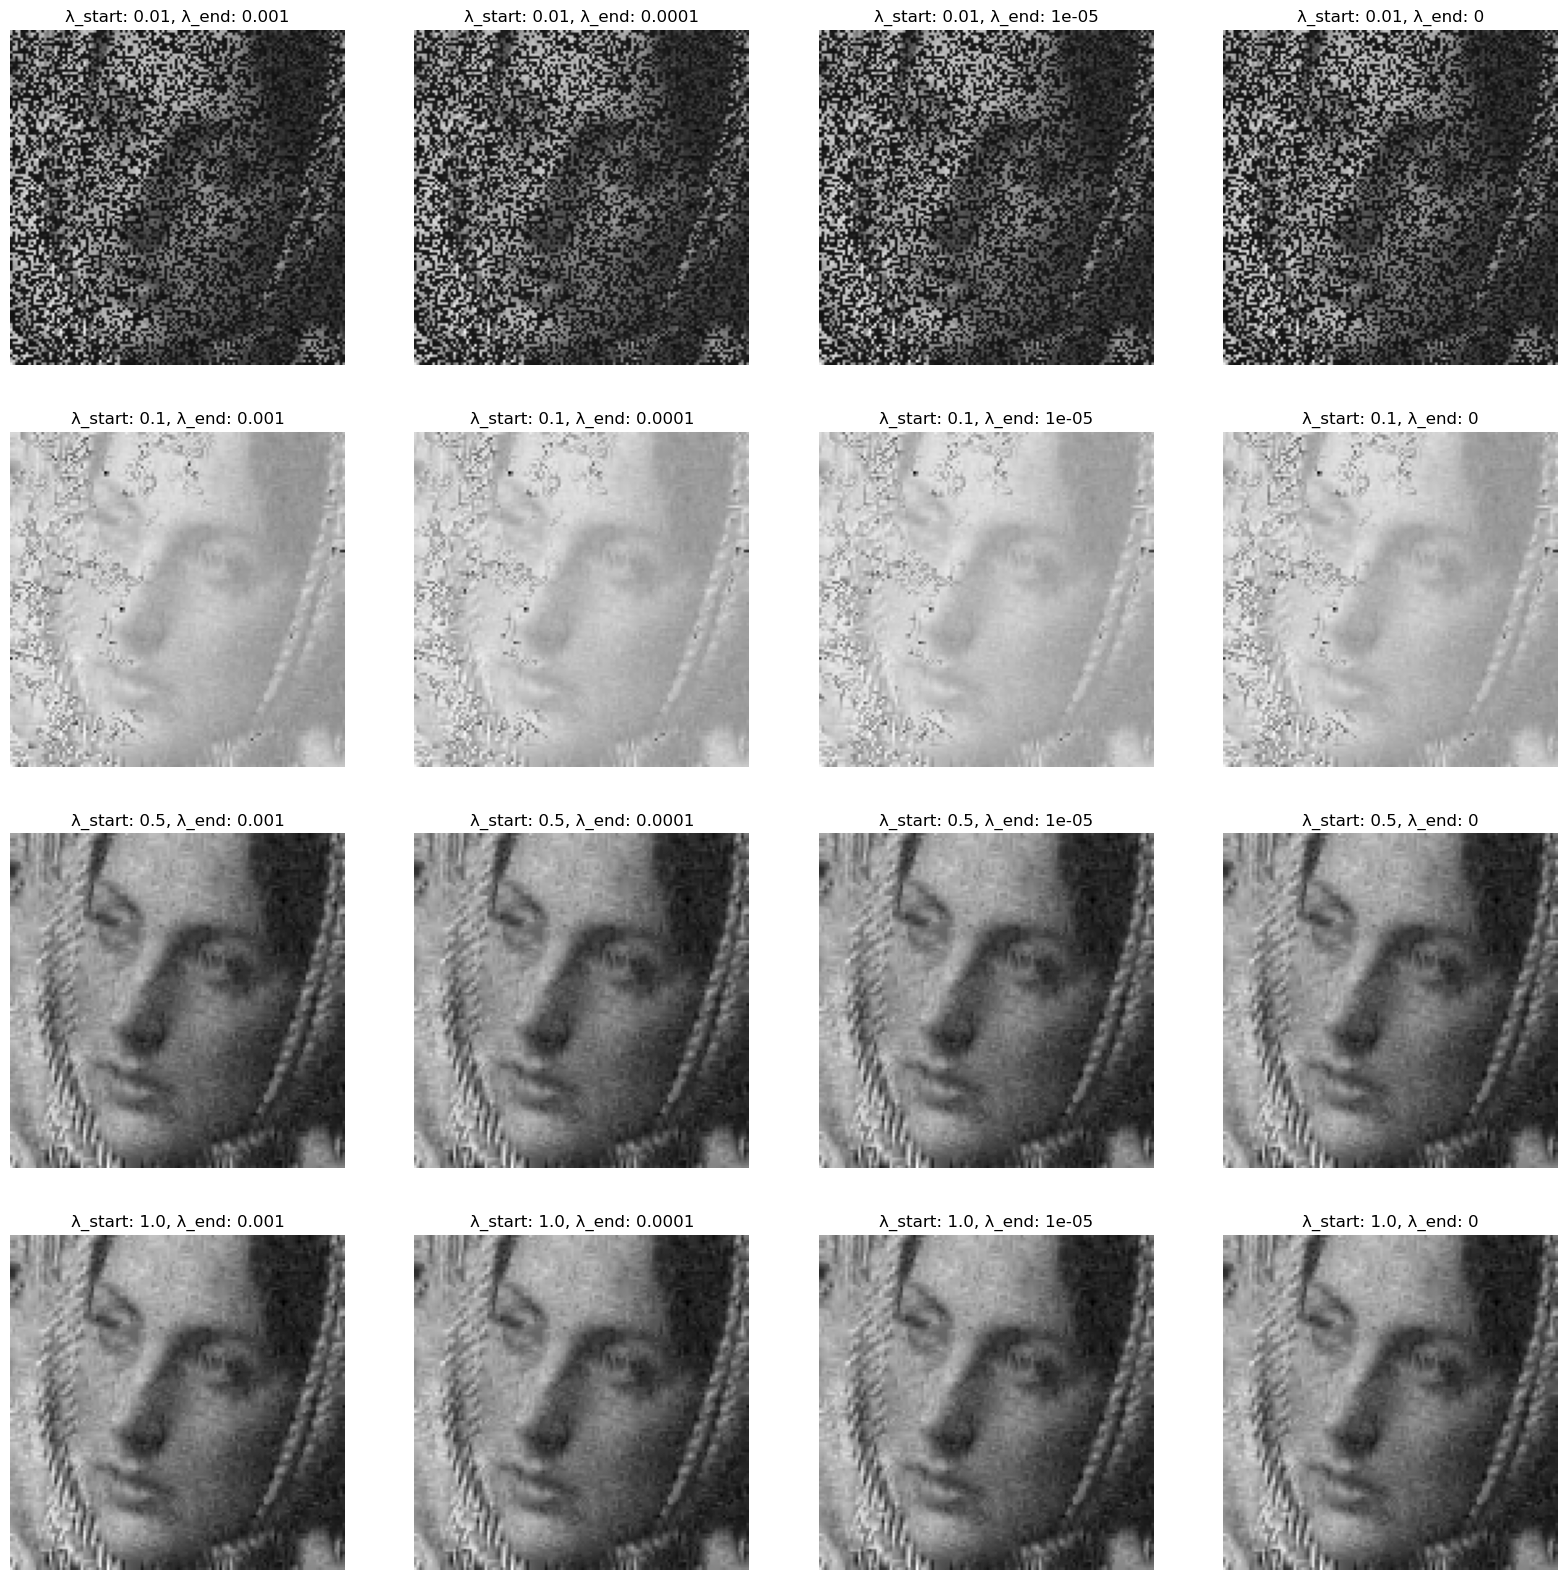

In [18]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for i, (lamb_start, lamb_end) in enumerate(solutions.keys()):
    axes[i//4, i%4].imshow(solutions[(lamb_start, lamb_end)], cmap='gray')
    axes[i//4, i%4].set_title(f'\u03bb_start: {lamb_start}, \u03bb_end: {lamb_end}')
    axes[i//4, i%4].axis('off')

Upon examining the series of images generated by varying the values of lamb_start and lamb_end, we can discern distinct visual patterns influenced by these parameters. The images clearly showcase a transition in clarity and noise distribution as the lambda values change.

High Starting Lambda (lamb_start: 0.01): The images begin in a state of high noise and are virtually unrecognizable. This suggests that a higher starting lambda might initially hinder the image reconstruction process.

Mid to Low Lambda Start Values (lamb_start: 0.1 to 1.0): The images are more recognizable from the beginning, indicating that the starting value of lambda plays a crucial role in the initial clarity. Lower lamb_start values tend to yield better initial reconstructions.

The best starting lambdas are between 0.5 and 1. We can really recognize the image from the beginning.

### 2. For the soft thresholding

In [19]:
solutions = {}

for lamb_start in [0.01, 0.1, 0.5, 1.]:
    for lamb_end in [1e-3, 1e-4, 1e-5, 0]:
        solved_image = soft_solution(img_damaged, niter=500, lamb_start=lamb_start, lamb_end=lamb_end, ti=1, filter='linear')
        solutions[(lamb_start, lamb_end)] = solved_image

100%|██████████| 500/500 [00:03<00:00, 142.00it/s]


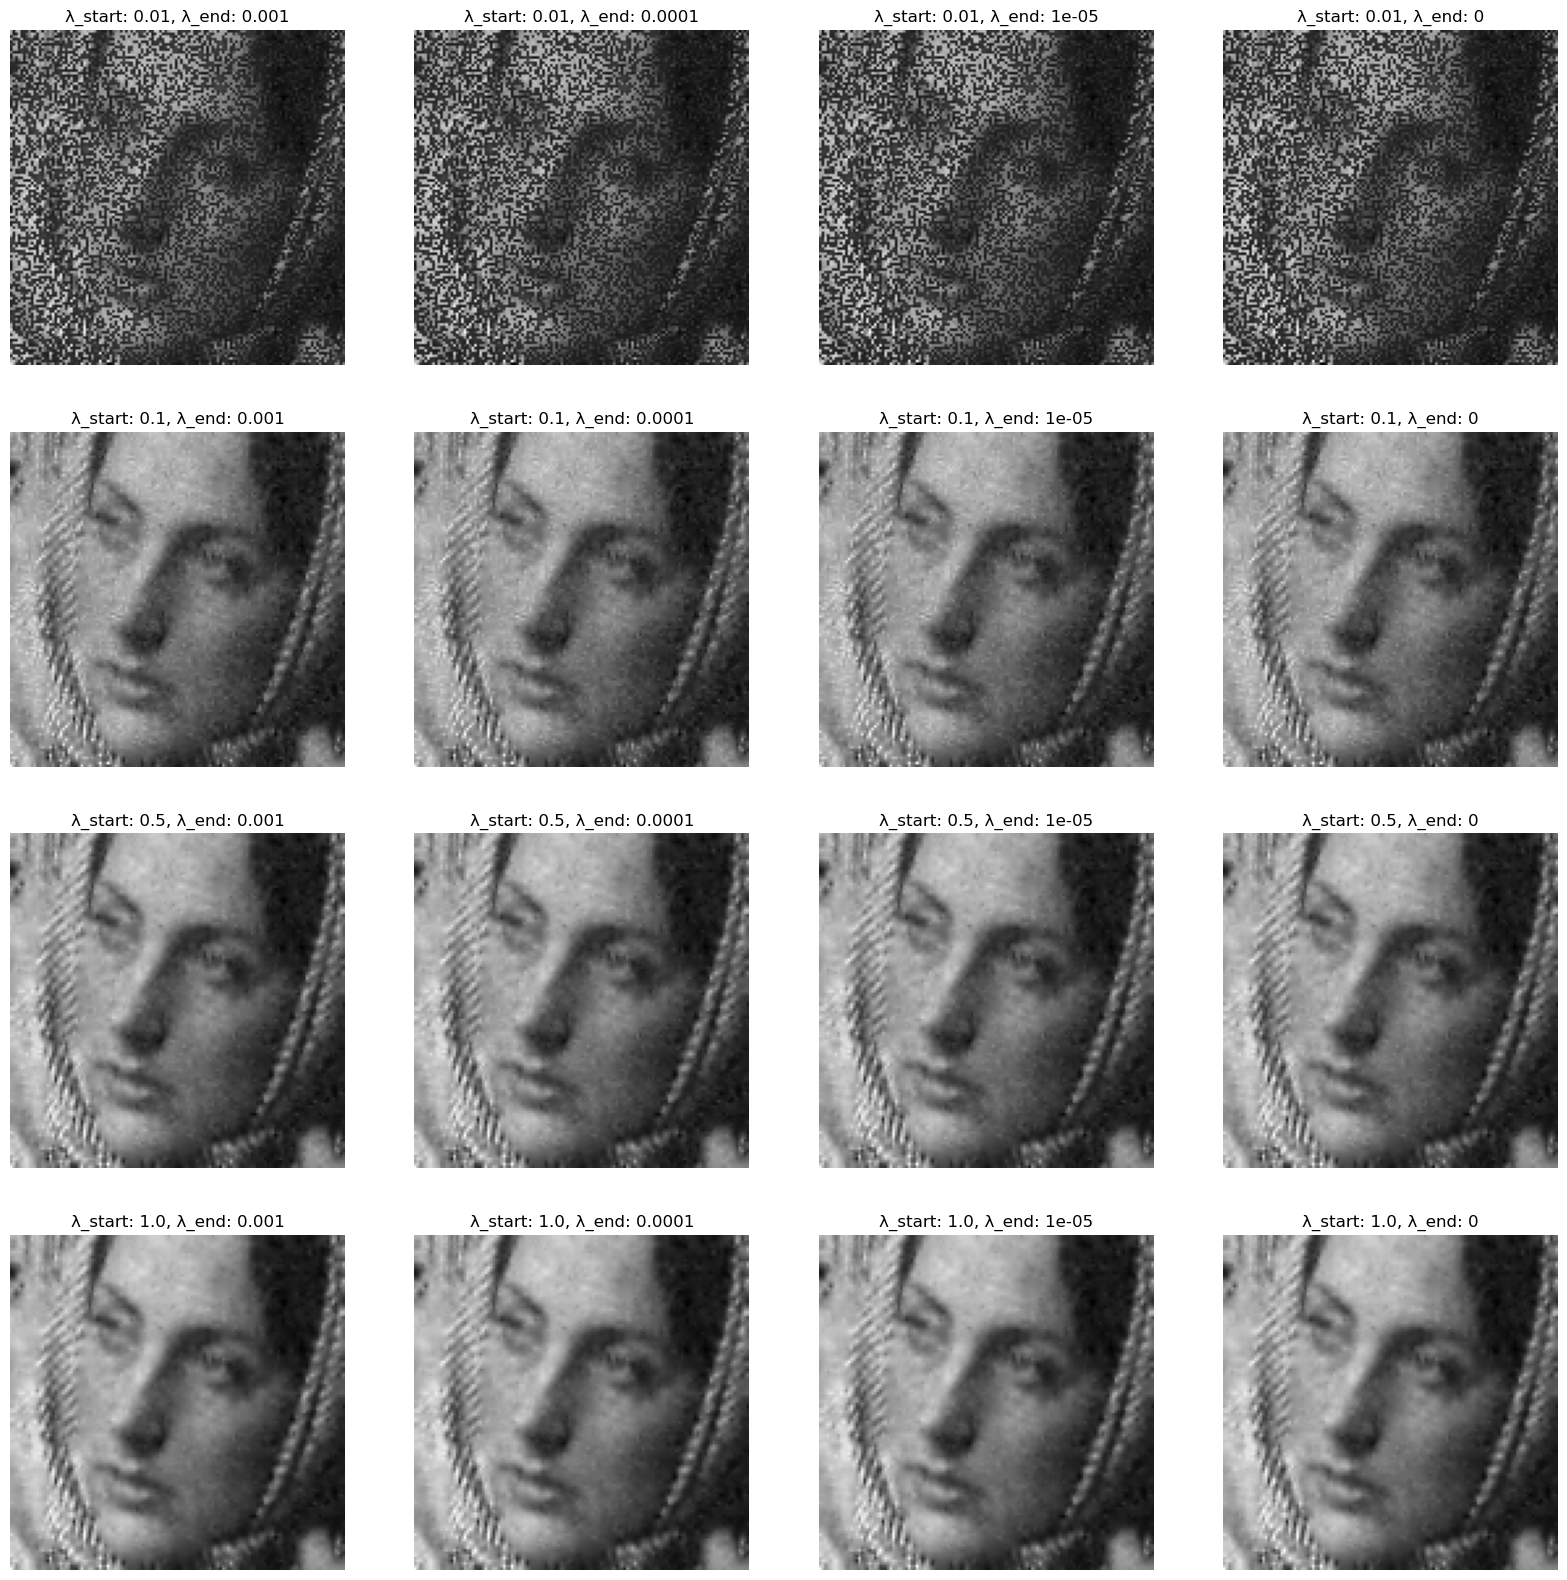

In [20]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for i, (lamb_start, lamb_end) in enumerate(solutions.keys()):
    axes[i//4, i%4].imshow(solutions[(lamb_start, lamb_end)], cmap='gray')
    axes[i//4, i%4].set_title(f'\u03bb_start: {lamb_start}, \u03bb_end: {lamb_end}')
    axes[i//4, i%4].axis('off')

We get similar results as before, except that this time we can start recognizing the image from a lower starting lambda. In fact with a starting lambda of 0.1, we can already recognize the image.

# Changing p 

100%|██████████| 50/50 [00:00<00:00, 124.61it/s]


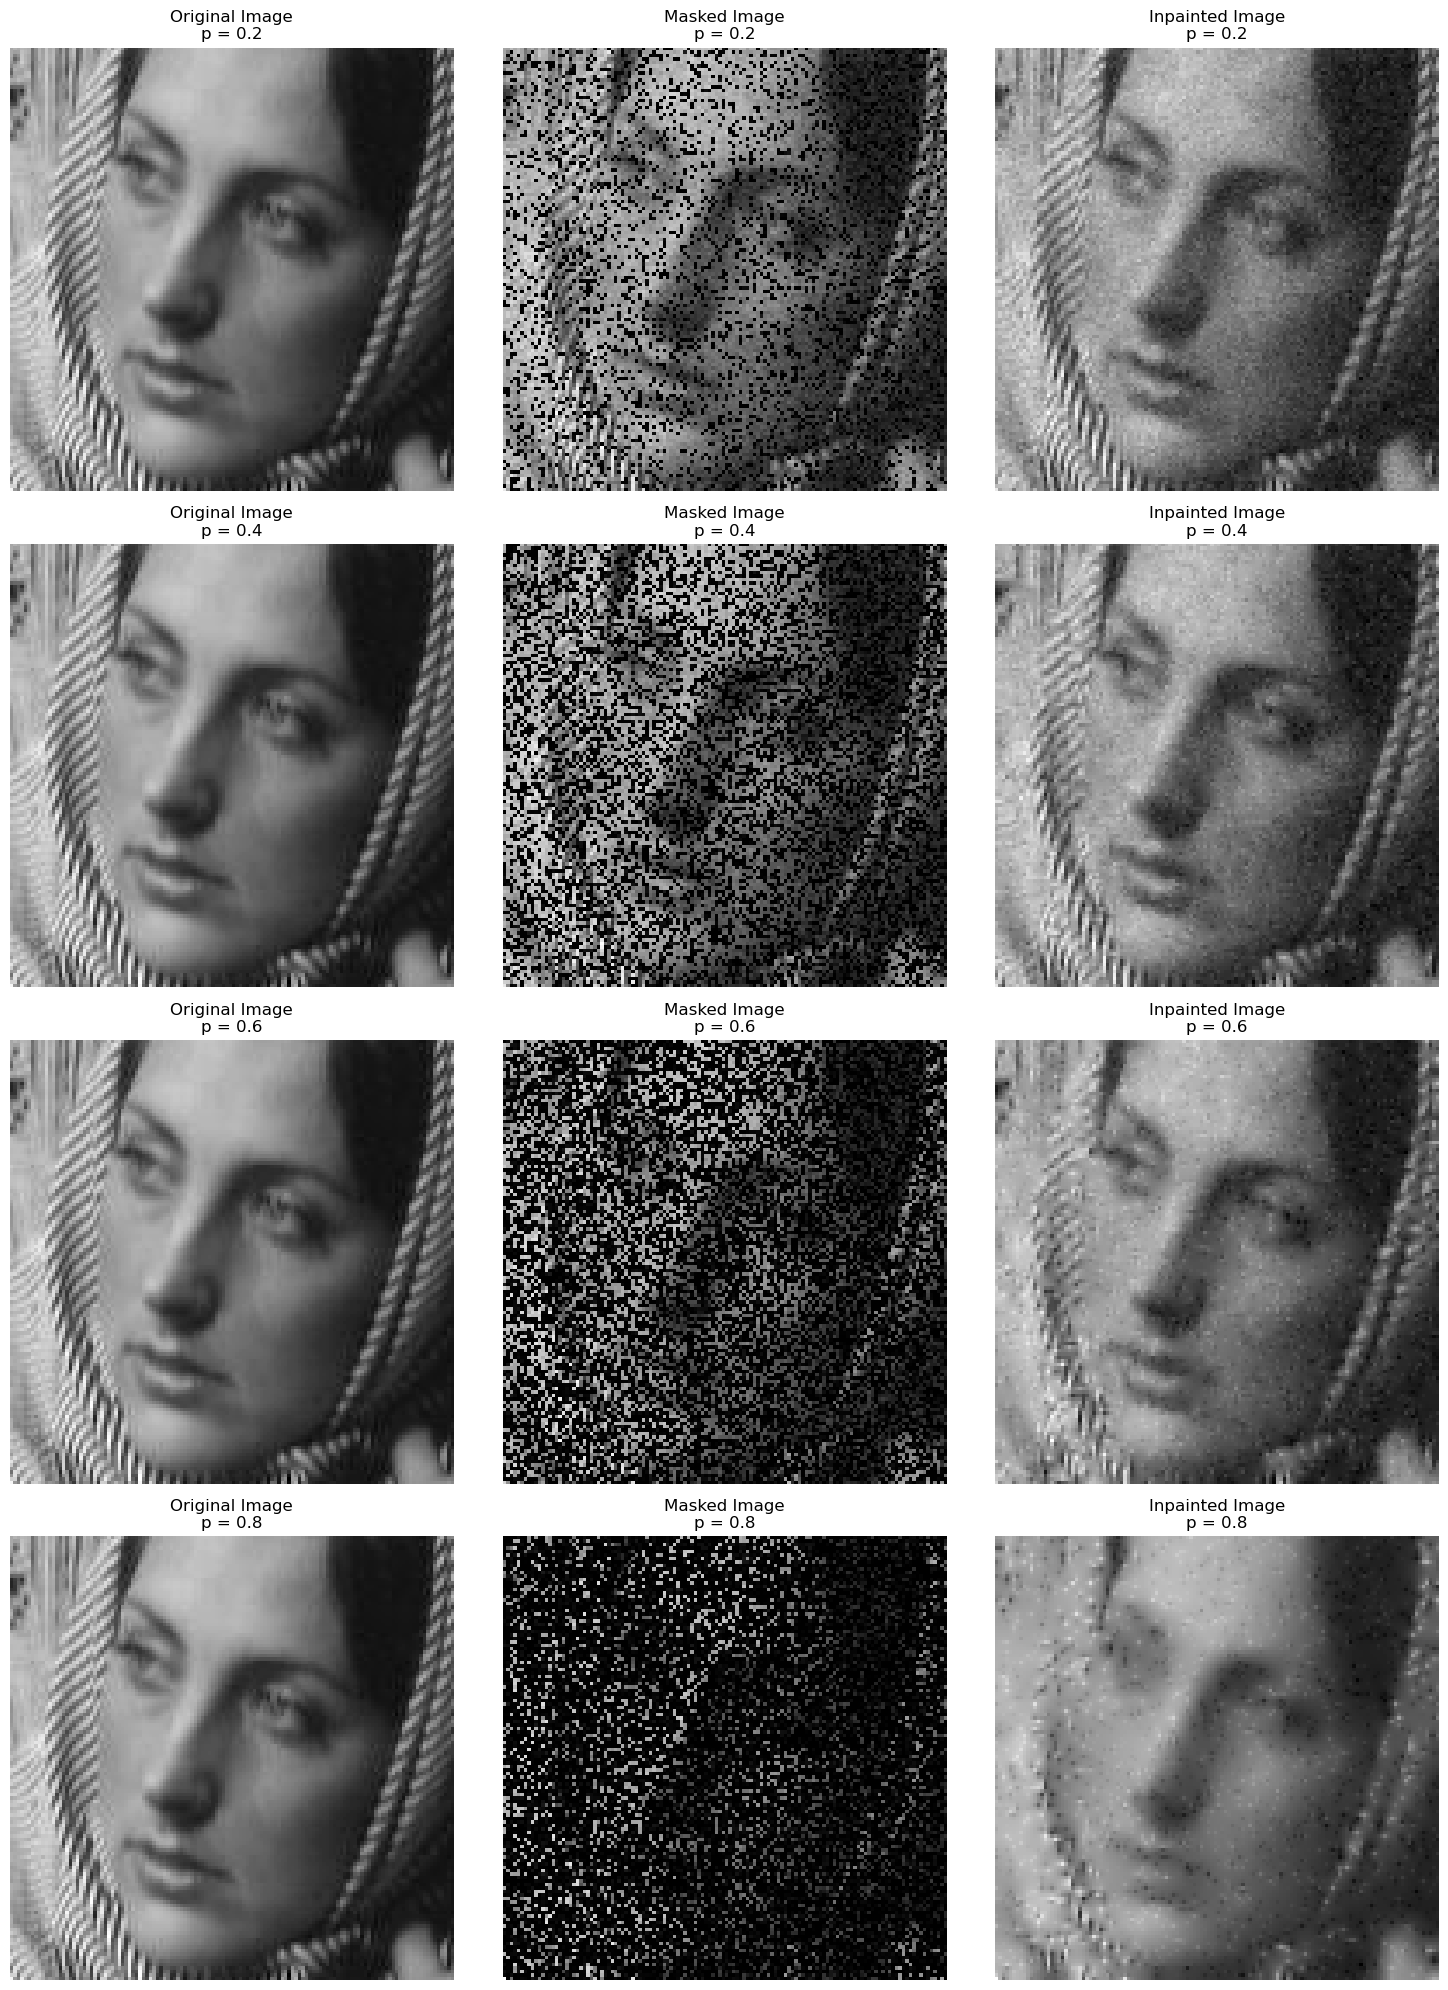

In [21]:
p_values = [0.2, 0.4, 0.6, 0.8]
solutions = {}

fig, axs = plt.subplots(len(p_values), 3, figsize=(15, 5 * len(p_values)))

for i, p in enumerate(p_values):
    img_damaged, mask = generate_problem(img, p=p, snr=50)
    
    ti = 1  # Example value for ti
    filter_value = 'linear'  # Example value for filter
    inpainted_img = hard_solution(img_damaged, niter=50, lamb_start=1, lamb_end=0, ti=ti, filter=filter_value)
    
    solutions[(p, ti, filter_value)] = inpainted_img
    
    # Display the original, masked, and inpainted images
    axs[i, 0].imshow(img, cmap='gray')
    axs[i, 0].set_title(f'Original Image\np = {p}')
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(img_damaged, cmap='gray')
    axs[i, 1].set_title(f'Masked Image\np = {p}')
    axs[i, 1].axis('off')
    
    axs[i, 2].imshow(inpainted_img, cmap='gray')
    axs[i, 2].set_title(f'Inpainted Image\np = {p}')
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()

Masked Images
p = 0.2: At this level, approximately 20% of the image pixels have been masked out, resulting in a speckled appearance. The masked pixels are randomly distributed.

p = 0.4: The severity of masking increases, with 40% of the image pixels masked out. The portrait's features are becoming harder to discern.

p = 0.6: At 60%, a substantial portion of the image has been obscured, making it increasingly challenging to recognize the details.

p = 0.8: With 80% of the pixels masked, the image is severely disrupted, and it's tough to determine the original content.

Inpainted Images

p = 0.2: The inpainted image at this level appears quite close to the original, indicating that the inpainting algorithm has performed well.

p = 0.4: As the masked region increases, the inpainting begins to blur the details slightly, but the overall portrait is still reasonably clear.

p = 0.6: The inpainting struggles more at this level. The face's features, like the eyes and lips, begin to distort, and the overall image lacks sharpness.

p = 0.8: The heavy masking results in significant blurring and distortion in the inpainted image. The original features are barely recognizable.

# Changing the SNR

100%|██████████| 50/50 [00:00<00:00, 164.06it/s]


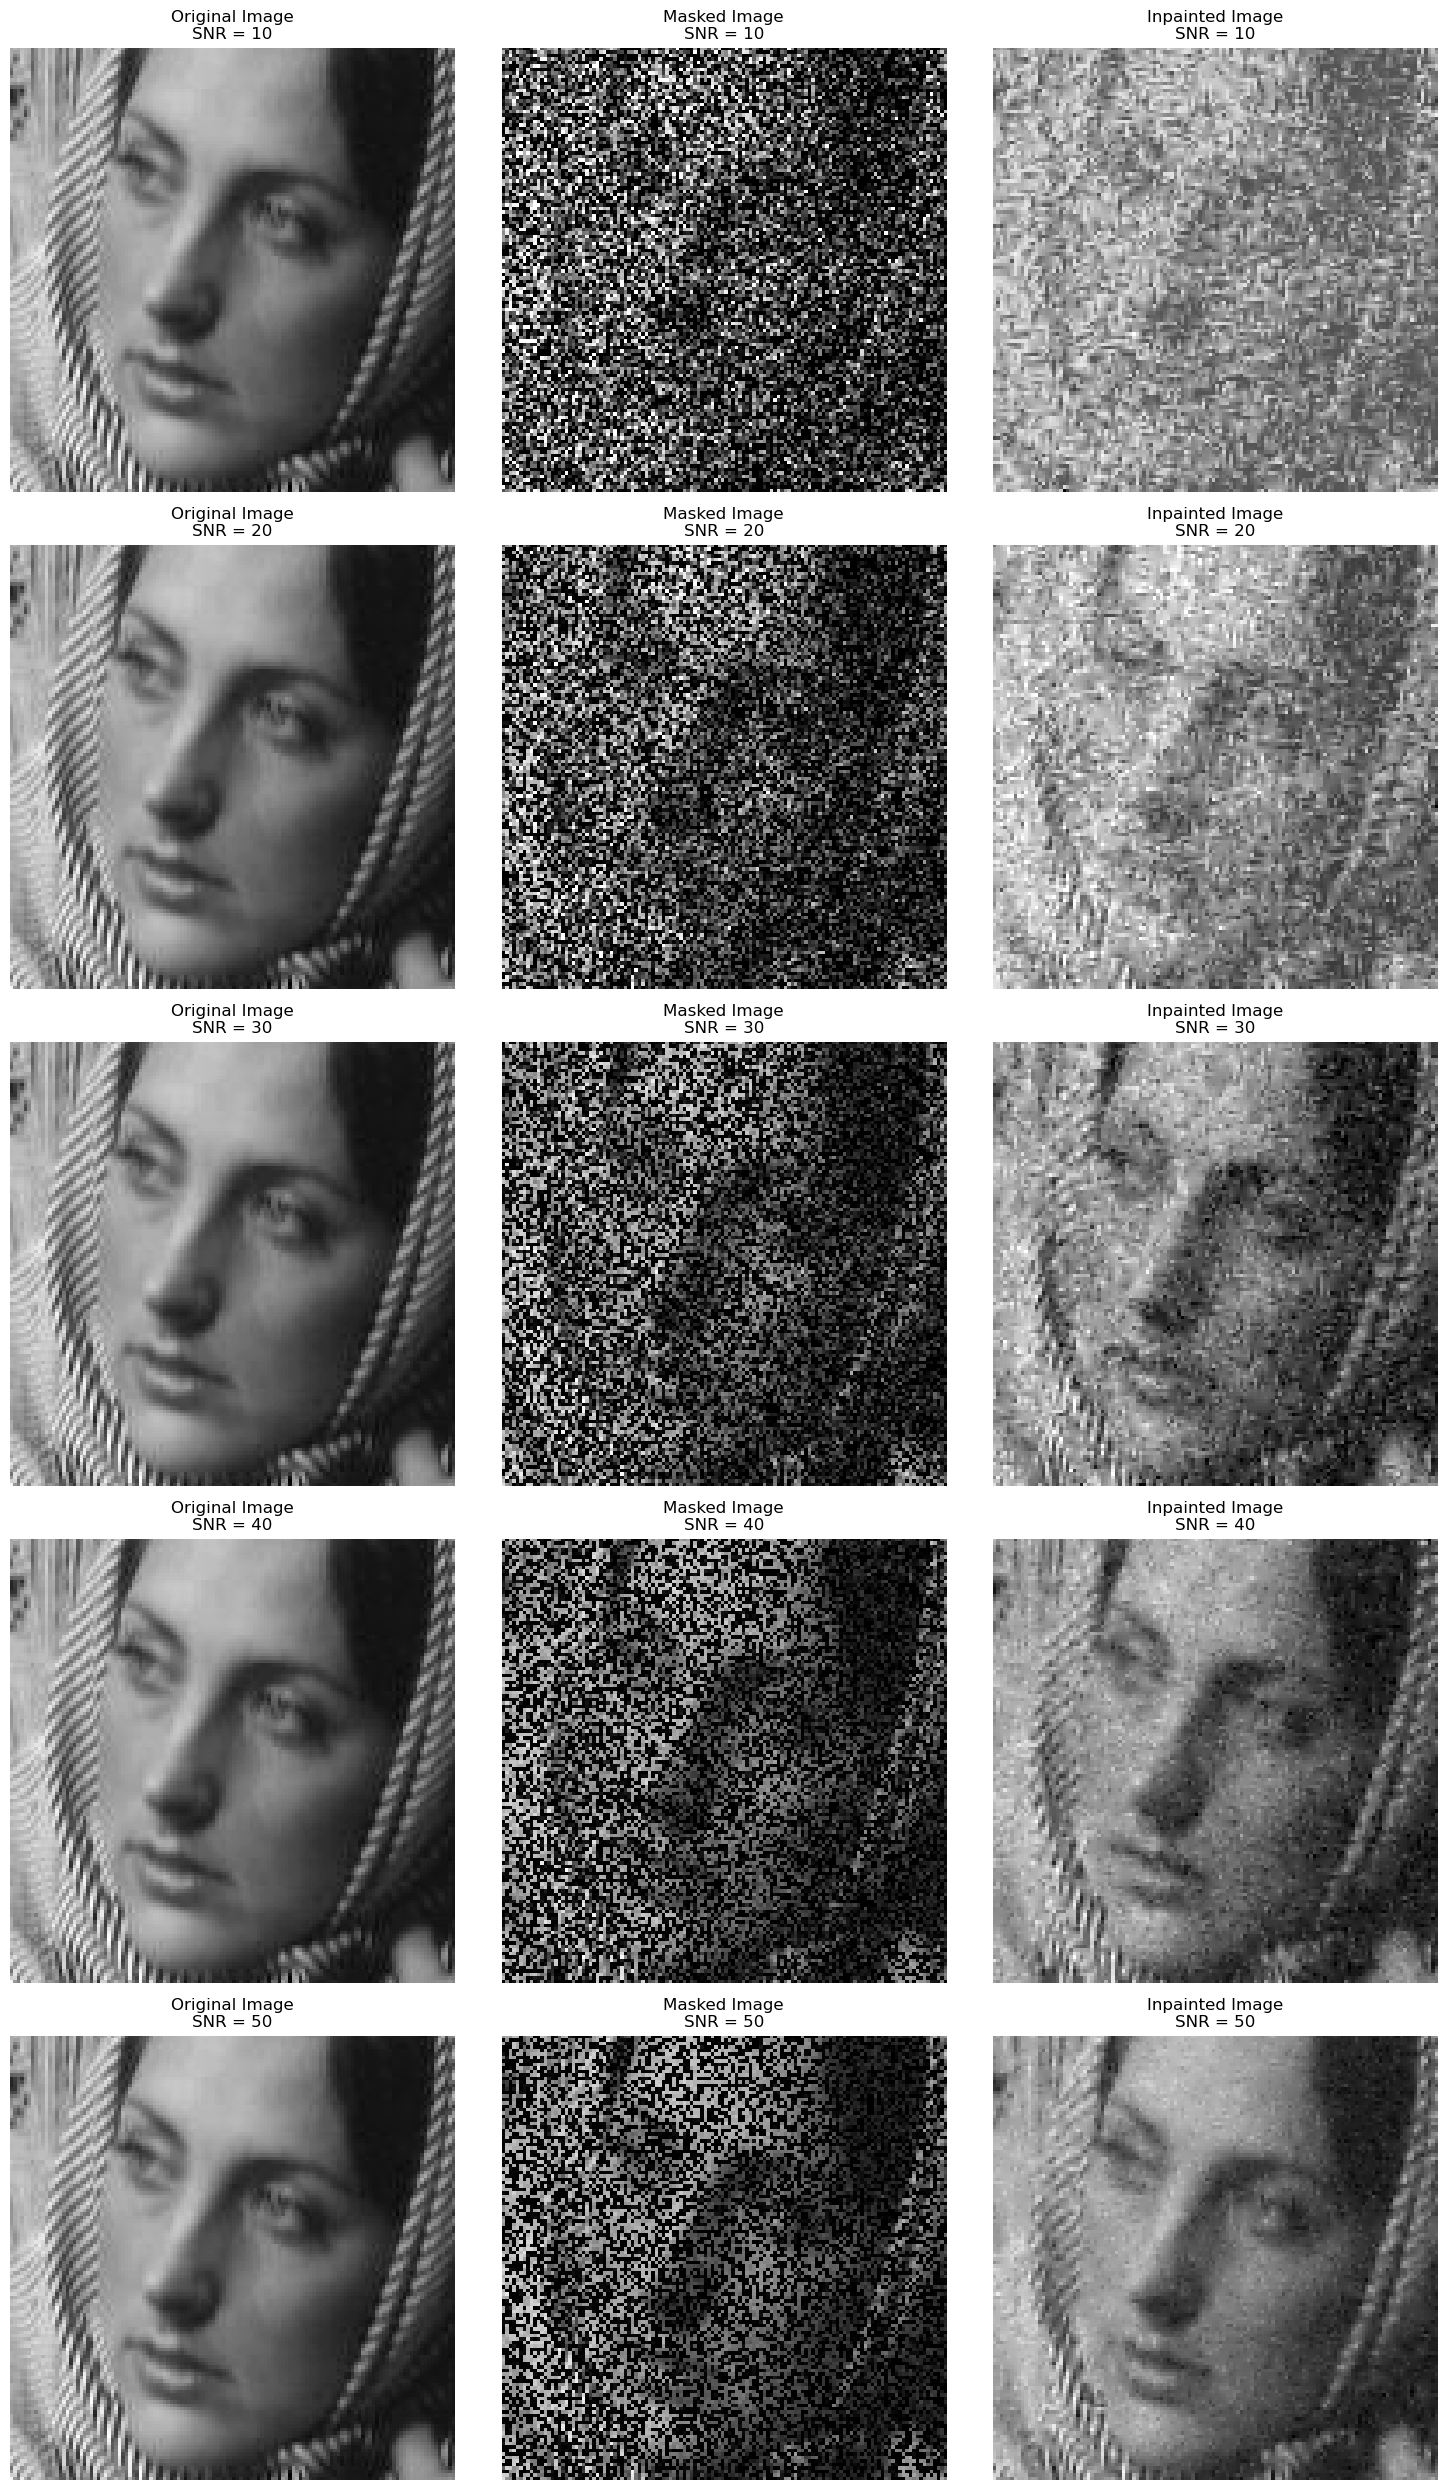

In [22]:
snr_values = [10, 20, 30, 40, 50]

fig, axs = plt.subplots(len(snr_values), 3, figsize=(15, 5 * len(snr_values)))

fixed_p = 0.5

for i, snr in enumerate(snr_values):
    img_damaged, mask = generate_problem(img, p=fixed_p, snr=snr)
    
    ti = 1  # Example value for ti
    filter_value = 'linear'  # Example value for filter
    inpainted_img = hard_solution(img_damaged, niter=50, lamb_start=1, lamb_end=0, ti=ti, filter=filter_value)
    
    solutions[(fixed_p, snr, ti, filter_value)] = inpainted_img
    
    axs[i, 0].imshow(img, cmap='gray')
    axs[i, 0].set_title(f'Original Image\nSNR = {snr}')
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(img_damaged, cmap='gray')
    axs[i, 1].set_title(f'Masked Image\nSNR = {snr}')
    axs[i, 1].axis('off')
    
    axs[i, 2].imshow(inpainted_img, cmap='gray')
    axs[i, 2].set_title(f'Inpainted Image\nSNR = {snr}')
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()


Influence of SNR: As the SNR value increases from 10 to 50, there is a noticeable change in the masked and inpainted images. The clarity of the inpainted image tends to improve as the SNR value rises.

Masked Images:

SNR = 10: The masked image has a high degree of noise.
SNR = 20: Noise remains significant, with a slight reduction compared to the SNR 10 scenario.
SNR = 30: The underlying features of the original image start to emerge amidst the noise.
SNR = 40: More facial features become discernible.
SNR = 50: The masked image displays even clearer contours of the face.
Inpainted Images:

SNR = 10: The restoration attempt results in a blurry rendition of the original image.
SNR = 20: While slightly better than the SNR 10 result, the image remains notably distorted.
SNR = 30: The image starts showing clearer features, especially in facial areas.
SNR = 40: Further clarity is observed, though some blur persists.
SNR = 50: This rendition is closest to the original image among all inpainted versions, though minor imperfections remain.